In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2, tau_R, tau_P, F_rad_strongDW
from unchanged_values import r, r_au, sD1_log, Ω, T_req

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

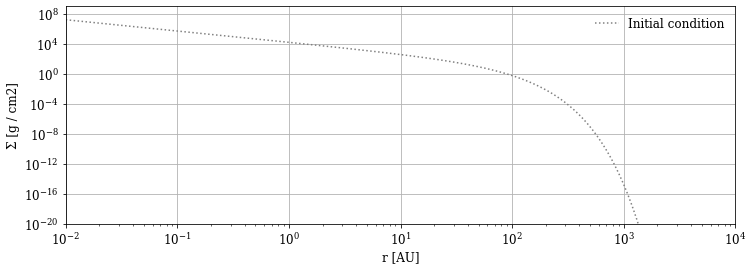

In [2]:
fig, axs = plt.subplots(figsize = (12,4))
axs.grid(ls='-')
axs.loglog(r_au, Σ_initial(r_au), ls=':', c= 'grey', label = 'Initial condition')
axs.set(ylabel = f'Σ [{Σ_initial(r_au).unit}]', xlabel = f'r [{r_au.unit}]', ylim = (1e-20, 1e9), xlim = (0.01, 1e4));
axs.legend(frameon=False)

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$

### Temperature from irradition
$$T_{1au}=280K\quad p=-1/2$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

Text(0.5, 0, 'Distance from star [AU]')

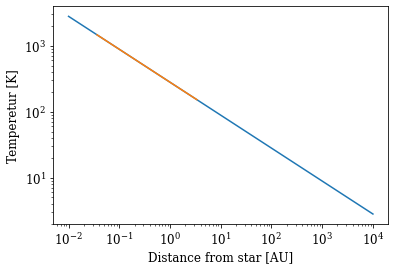

In [3]:
plt.loglog(r, T_req)
plt.loglog(r[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))], T_req[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))])
plt.ylabel('Temperetur [K]')
plt.xlabel('Distance from star [AU]')

Text(0.5, 0, 'Distance from star [AU]')

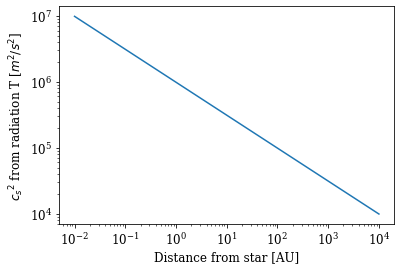

In [4]:
plt.loglog(r, c_s2(T_req)) 
c_s2(T_req).unit, T_req.unit
plt.ylabel('${c_s}^2$ from radiation T [$m^2/s^2$]')
plt.xlabel('Distance from star [AU]')

### Temperature at midplane
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{2\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$
### $F_{rad}$ for the strong DW case (p. 4 Suzuki)
$$F_{rad} = max\left(-\frac{1}{r}\partial_r r^2 \Sigma \Omega α_{rφ} c_s^2,\;0\right)$$
$$[r^2 \Sigma \Omega α_{rφ} c_s^2] = \frac{m^2kg}{s^3}\quad\Rightarrow\quad [F_{rad}]=\frac{kg}{s^3}$$


1 / s
5.6703744191844314e-08 kg / (K4 s3)


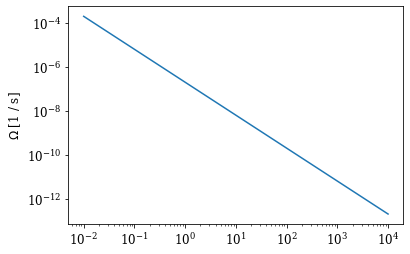

In [5]:
plt.loglog(r, Ω)
plt.ylabel(f'$\Omega$ [{Ω.unit}]')
print(Ω.unit) 
print(sigma_sb.decompose())

Unit("kg m2 / s3")

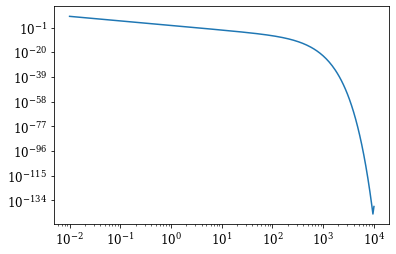

In [6]:
α_rφ = 8e-5
func_to_der = (r_au**2 * Σ_initial(r_au) * Ω * α_rφ * c_s2(T_req)).decompose()
F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()

plt.loglog(r, F_rad)
F_rad[F_rad < 0]
func_to_der.unit

In [7]:
test = np.array([3])
type(test) == np.ndarray
type(T_req)

astropy.units.quantity.Quantity

In [8]:
'''### Opacity ###
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        TT = (T.value).copy()
    else:
        TT = T.copy()
    κ = np.zeros_like(TT)

    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 

    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 

    κ[TT > 1500] = 0 # Støvet fordamper og går i stykker 

    return κ * (Σ.to('g/cm2')).value / 2


def tau_P(τ_R):
    τ_P = τ_R.copy()
    τ_P[2.4 * τ_P <= 0.5] = 0.5
    τ_P[τ_P != 0.5] = 2.4 * τ_P[τ_P != 0.5]
    return τ_P'''

"### Opacity ###\ndef tau_R(T, Σ):\n    if type(T) != np.ndarray:\n        TT = (T.value).copy()\n    else:\n        TT = T.copy()\n    κ = np.zeros_like(TT)\n\n    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 \n\n    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 \n\n    κ[TT > 1500] = 0 # Støvet fordamper og går i stykker \n\n    return κ * (Σ.to('g/cm2')).value / 2\n\n\ndef tau_P(τ_R):\n    τ_P = τ_R.copy()\n    τ_P[2.4 * τ_P <= 0.5] = 0.5\n    τ_P[τ_P != 0.5] = 2.4 * τ_P[τ_P != 0.5]\n    return τ_P"

In [9]:
'''def F_rad_func(Σ, cs2):
    func_to_der = (r_au**2 * Σ * Ω * α_rφ * cs2).decompose()
    F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()
    F_rad_nounit = F_rad.value
    F_rad_nounit[F_rad_nounit <= 0] = 0
    return F_rad_nounit * F_rad.unit'''

'def F_rad_func(Σ, cs2):\n    func_to_der = (r_au**2 * Σ * Ω * α_rφ * cs2).decompose()\n    F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()\n    F_rad_nounit = F_rad.value\n    F_rad_nounit[F_rad_nounit <= 0] = 0\n    return F_rad_nounit * F_rad.unit'

In [10]:
F_rad_strongDW(T_req, Σ_initial(r_au)).to('W/m2') # It's a flux

<Quantity [4.01091987e+007, 3.41498309e+007, 2.90503959e+007,
           2.47124292e+007, 2.10222262e+007, 1.78830605e+007,
           1.52126494e+007, 1.29409969e+007, 1.10085588e+007,
           9.36468234e+006, 7.96627836e+006, 6.77669191e+006,
           5.76474146e+006, 4.90390160e+006, 4.17160782e+006,
           3.54866498e+006, 3.01874426e+006, 2.56795511e+006,
           2.18448118e+006, 1.85827057e+006, 1.58077240e+006,
           1.34471261e+006, 1.14390337e+006, 9.73080828e+005,
           8.27767162e+005, 7.04153202e+005, 5.98998583e+005,
           5.09546812e+005, 4.33453010e+005, 3.68722449e+005,
           3.13658270e+005, 2.66816997e+005, 2.26970706e+005,
           1.93074835e+005, 1.64240803e+005, 1.39712721e+005,
           1.18847574e+005, 1.01098368e+005, 8.59997909e+004,
           7.31560162e+004, 6.22303255e+004, 5.29362826e+004,
           4.50302252e+004, 3.83048774e+004, 3.25839161e+004,
           2.77173489e+004, 2.35775823e+004, 2.00560767e+004,
        

In [11]:
(sigma_sb*(280 *u.K)**4).value

348.5329658998226

348.5329658998226 W / m2


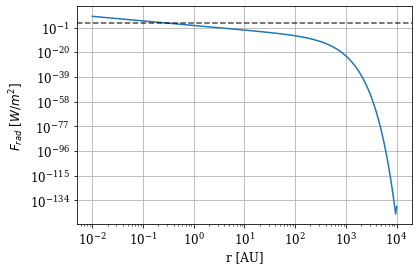

In [12]:
plt.loglog(r, F_rad_strongDW(T_req, Σ_initial(r_au)))
plt.grid()
plt.ylabel('$F_{rad}$'+' [$W/m^2$]')
plt.xlabel(f'r [{r_au.unit}]')
print(sigma_sb * (280 *u.K)**4)
plt.axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black')
#plt.ylim(1e-10,1e5)
# The offest is due to α_rφ is set to be 3e-5

In [13]:
def opacity(T, Σ):
    return (3/8 * tau_R(T, Σ) + (2 * tau_P(tau_R(T, Σ)))**(-1))**0.25

In [14]:
def T_vis(T, Σ):
    return (opacity(T, Σ) * ((0.5 * sigma_sb**(-1)) * F_rad_strongDW(T, Σ))**(0.25)).decompose()

In [15]:
T_vis(T_req, Σ_initial(r_au))

<Quantity [4.33661196e+03, 4.16568769e+03, 4.00062257e+03, 3.84209791e+03,
           3.68985456e+03, 3.54364378e+03, 3.40322723e+03, 3.26837875e+03,
           3.13889387e+03, 3.01463358e+03, 2.89571188e+03, 2.78326543e+03,
           2.68245112e+03, 2.61199610e+03, 2.13406342e+03, 2.53398655e+03,
           3.36212059e+03, 4.47170105e+03, 5.90526363e+03, 7.73915916e+03,
           1.00665961e+04, 1.29972200e+04, 1.66562652e+04, 2.11759484e+04,
           2.66579731e+04, 3.30431489e+04, 3.97685503e+04, 4.53626704e+04,
           4.81655327e+04, 4.81354948e+04, 4.65095303e+04, 4.42911177e+04,
           4.19439197e+04, 3.96387182e+04, 3.74312008e+04, 3.53362468e+04,
           3.33547473e+04, 3.14829296e+04, 2.97155899e+04, 2.80472207e+04,
           2.64724034e+04, 2.49859404e+04, 2.35828941e+04, 2.22585915e+04,
           2.10086166e+04, 1.98287995e+04, 1.87152035e+04, 1.76641123e+04,
           1.66720180e+04, 1.57356097e+04, 1.48517622e+04, 1.40175255e+04,
           1.32301155e+04

In [16]:
T_req

<Quantity [2800.        , 2736.05350835, 2673.56742878, 2612.50840833,
           2552.8438558 , 2494.54192426, 2437.57149415, 2381.90215658,
           2327.50419717, 2274.34858013, 2222.40693282, 2171.65153055,
           2122.05528182, 2073.59171383, 2026.2349584 , 1979.9597381 ,
           1934.7413528 , 1890.55566646, 1847.37909427, 1805.18859005,
           1763.96163395, 1723.67622042, 1684.31084648, 1645.84450024,
           1608.25664967, 1571.52723167, 1535.63664131, 1500.56572144,
           1466.29575238, 1432.80844199, 1400.0859159 , 1368.11070792,
           1336.8657508 , 1306.33436703, 1276.50025999, 1247.34750528,
           1218.86054212, 1191.02416517, 1163.8235163 , 1137.24407675,
           1111.2716593 , 1085.89240077, 1061.09275458, 1036.85948352,
           1013.1796527 ,  990.04062263,  967.43004249,  945.33584351,
            923.74623258,  902.64968588,  882.03494281,  861.89099992,
            842.20710505,  822.97275162,  804.17767298,  785.81183697,
      

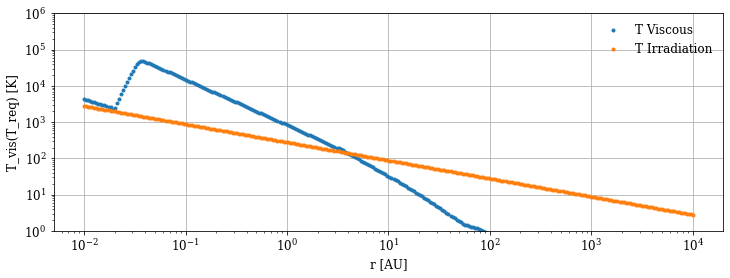

In [17]:
plt.figure(figsize = (12,4))
plt.loglog(r, T_vis(T_req, Σ_initial(r_au)),'.', label = 'T Viscous')
plt.loglog(r, T_req, '.', label = 'T Irradiation')
plt.grid()
plt.ylabel('T_vis(T_req)'+f' [{T_vis(T_req, Σ_initial(r_au)).unit}]')
plt.xlabel(f'r [{r_au.unit}]')
plt.ylim(1, 1e6)
plt.legend(frameon = False)
# Falder opaciteten altså den bliver gennemsigtig falder temperaturen fordi der ikke er noget til at holde på varmen

In [18]:
def guess_T(T):
    T_new4 = T_vis(T, Σ_initial(r_au)).value**4 + T_req.value**4
    return T_new4**0.25 * u.K

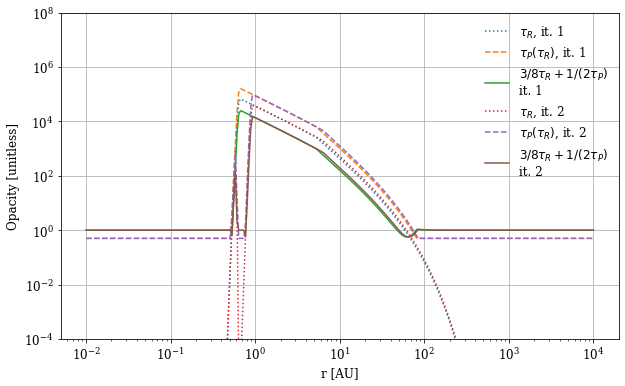

In [19]:
fig, axs = plt.subplots(figsize = (10, 6))

T0 = T_req
T_list = [T_req]
for i in range(2):
    T_new = guess_T(T_list[-1])
    T_damp = (T_list[-1]**4 + T_new**4)**0.25
    T_list.append(T_damp)


axs.grid()
for i, T in enumerate(T_list[1:]):
    axs.loglog(r, tau_R(T, Σ_initial(r_au)), label = f'$τ_R$, it. {i+1}', ls = ':')
    axs.loglog(r, tau_P(tau_R(T, Σ_initial(r_au))), label = f'$τ_P(τ_R)$, it. {i+1}', ls='--')
    axs.set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8))
    axs.loglog(r, (3/8 * tau_R(T, Σ_initial(r_au)) + 0.5 * tau_P(tau_R(T, Σ_initial(r_au)))**(-1)), label = '$3/8 τ_R + 1/(2τ_P)}$\n'+f'it. {i+1}')
#axs[1].axhline(0.5, c='grey', label = 'τ_P_{min}')
axs.legend(frameon = False)

In [20]:
# Opacity check check check - DAMP

T0 = T_req
T_list = [T_req]
for i in range(11):
    T_new = guess_T(T_list[-1])
    if i < 5:
        T_new[T_new > 2800 * u.K] = 2800 *u.K
    T_damp = (0.5*(T_list[-1]**4 + T_new**4))**0.25
    T_list.append(T_damp)


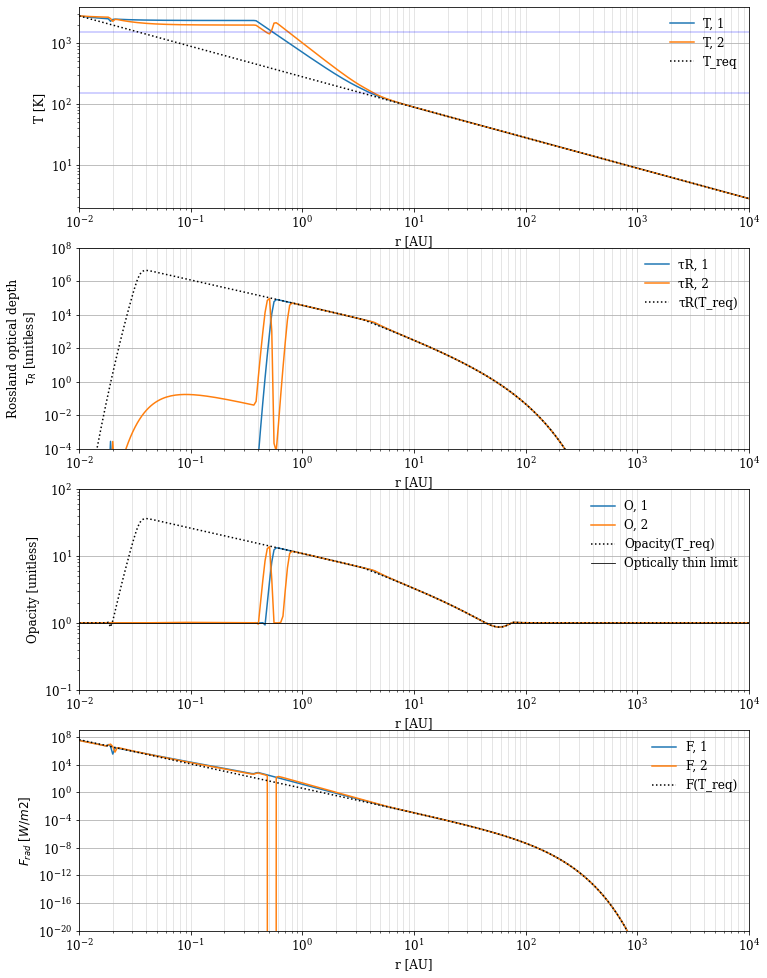

In [21]:
fig, axs = plt.subplots(4,1, figsize = (12,17))
for ax in axs:
    ax.grid(which = 'major', axis= 'y')
    ax.grid(which = 'both', axis= 'x', alpha = 0.4)

iterations_to_plot = np.array([1, 2])
for i in iterations_to_plot:
    axs[0].loglog(r_au, T_list[i], label = f'T, {i}')
    axs[1].loglog(r_au, tau_R(T_list[i], Σ_initial(r_au)), label = f'τR, {i}')
    axs[2].loglog(r_au, opacity(T_list[i], Σ_initial(r_au)), label = f'O, {i}')
    axs[3].loglog(r_au, F_rad_strongDW(T_list[i], Σ_initial(r_au)), label = f'F, {i}')


axs[0].axhline(1500, c='blue', alpha = 0.9, lw = 0.4)
axs[0].axhline(150, c='blue', alpha = 0.9, lw = 0.4)
axs[0].loglog(r_au, T_req, ls=':', c='black', label = 'T_req')
axs[1].loglog(r_au, tau_R(T_req, Σ_initial(r_au)), ls=':', c='black', label = 'τR(Τ_req)')
axs[2].loglog(r_au, opacity(T_req, Σ_initial(r_au)), ls=':', c='black', label = 'Opacity(T_req)')
axs[2].axhline(1, label = 'Optically thin limit', c='black', lw = 0.8)
axs[3].loglog(r_au, F_rad_strongDW(T_req, Σ_initial(r_au)), c = 'black', label = 'F(T_req)', ls=':')


axs[0].set(ylabel = 'T [K]', xlabel = 'r [AU]', xlim = (0.01, 1e4))
axs[1].set(ylabel = 'Rossland optical depth\n$τ_R$ [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8), xlim = (0.01, 1e4))
axs[2].set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-1, 1e2), xlim = (0.01, 1e4))
axs[3].set(ylabel = '$F_{rad}$ [$W/m2$]', xlabel = 'r [AU]', ylim = (1e-20, 1e9), xlim = (0.01, 1e4))


axs[0].legend(frameon =False, loc = 'upper right')
axs[1].legend(frameon =False, loc = 'upper right')
axs[2].legend(frameon =False, loc = 'upper right')
axs[3].legend(frameon =False, loc = 'upper right')

plt.savefig('../graphics/temp_investigation', dpi = 400)

In [22]:

for i, T in enumerate(T_list[1:]):
    axs[0].loglog(r_au, T, label = f'T, it. {i+1}')
axs[0].loglog(r, T_req, label = 'T Irradiation')
axs[0].set(ylabel = 'T [K]', xlabel = 'r [AU]')
axs[0].legend(frameon =False)

axs[1].grid()
for i, T in enumerate(T_list[1:]):
    axs[1].loglog(r, tau_R(T, Σ_initial(r_au)), label = f'$τ_R$, it. {i+1}', ls = ':')
    #axs[1].loglog(r, tau_P(tau_R(T, Σ_initial(r_au))), label = f'$τ_P(τ_R)$, it. {i+1}')
    axs[1].loglog(r, (3/8 * tau_R(T, Σ_initial(r_au)) + 0.5 * tau_P(tau_R(T, Σ_initial(r_au)))**(-1)), label = '$3/8 τ_R + 1/(2τ_P)}$\n'+f'it. {i+1}')
#axs[1].axhline(0.5, c='grey', label = 'τ_P_{min}')

axs[1].set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8))
axs[1].legend(frameon = False, ncol = 3)


axs[2].grid()
for i, T in enumerate(T_list[1:]):
    axs[2].loglog(r, F_rad_strongDW(Σ_initial(r_au), c_s2(T)), label = 'F_rad,'+f' it. {i+1}')
axs[2].set(ylabel = '$F_{rad}$ [$W/m2$]', xlabel = 'r [AU]', ylim = (1e-20, 1e9))
axs[2].axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black', label = '$\sigma_{SB}(280K)^4$')
axs[2].legend(frameon = False)




In [23]:
np.max(T_req)

<Quantity 2800. K>

NameError: name 'F_rad_func' is not defined

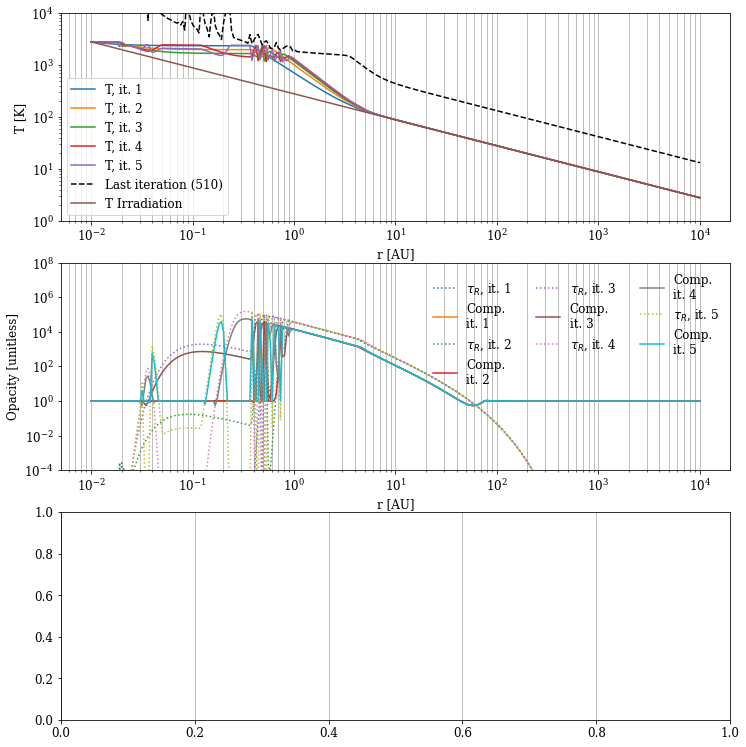

In [24]:
# Opacity check
fig, axs = plt.subplots(3,1, figsize = (12,13))
axs[0].grid(which = 'both', axis='x')

T0 = T_req
T_list2 = [T_req]
for i in range(500):
    T_new = guess_T(T_list[-1])
    if i < 5:
        T_new[T_new > 2800 * u.K] = 2800 *u.K
    T_damp = ((T_list[-1]**4 + T_new**4))**0.25
    T_list.append(T_damp)

for i, T in enumerate(T_list[1:]):
    if i < 5:
        axs[0].loglog(r_au, T, label = f'T, it. {i+1}')
axs[0].loglog(r, T_list[-1], c='black', label = f'Last iteration ({i})', ls='--')
axs[0].loglog(r, T_req, label = 'T Irradiation')
axs[0].set(ylabel = 'T [K]', xlabel = 'r [AU]', ylim = (1, 1e4))
axs[0].legend(frameon =True)

axs[1].grid(which = 'both', axis='x')
for i, T in enumerate(T_list[1:]):
    if i < 5:
        axs[1].loglog(r, tau_R(T, Σ_initial(r_au)), label = f'$τ_R$, it. {i+1}', ls = ':')
    #axs[1].loglog(r, tau_P(tau_R(T, Σ_initial(r_au))), label = f'$τ_P(τ_R)$, it. {i+1}')
        axs[1].loglog(r, (3/8 * tau_R(T, Σ_initial(r_au)) + 0.5 * tau_P(tau_R(T, Σ_initial(r_au)))**(-1)), label = 'Comp.\n'+f'it. {i+1}')
#axs[1].axhline(0.5, c='grey', label = 'τ_P_{min}')
#axs[1].loglog(r, T_list[-1], c='black', label = 'Last iteration')
axs[1].set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8))
axs[1].legend(frameon = False, ncol = 3)


axs[2].grid(which = 'both', axis='x')
for i, T in enumerate(T_list):
    if i < 5:
        axs[2].loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T)), label = 'F_rad,'+f' it. {i+1}')
axs[2].loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T_list[-1])), c='black', label = f'Last iteration ({i})', ls='--')
axs[2].set(ylabel = '$F_{rad}$ [$W/m2$]', xlabel = 'r [AU]', ylim = (1e-20, 1e9))
axs[2].axhline((sigma_sb*(280 *u.K)**4).value, alpha = 0.7, ls = '--', c = 'black', label = '$\sigma_{SB}(280K)^4$')
axs[2].legend(frameon = False)
#plt.subplots_adjust(wspace=0, hspace=1e-3)



Text(0.5, 1.0, 'Strong DW and MRI-inactive')

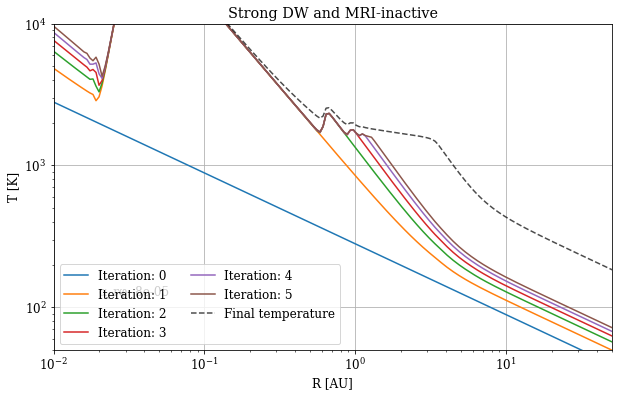

In [ ]:
T0 = T_req
T = [T_req]
for i in range(100):
    T_new = guess_T(T[-1])
    T_damp = (T[-1]**3 + T_new**3)**(1/3)
    T.append(T_damp)


plt.figure(figsize = (10,6))
plt.grid()
for i, t in enumerate(T):
    if i <= 5:
        plt.loglog(r, t, label=f'Iteration: {i}')
    #if i%15 == 0:
    #    plt.loglog(r, t, label=f'Iteration: {i}')
plt.loglog(r, T[-1], ls='--', c='black', label = 'Final temperature', alpha = 0.7)
plt.legend(ncol = 2)
plt.ylim(50,1e4)
plt.xlim(0.01, 50)
plt.ylabel(f'T [{T_damp.unit}]')
plt.xlabel('R [AU]')
plt.text(0.02, 1.2e2, f'α_rφ: {α_rφ}')
plt.title('Strong DW and MRI-inactive')

Text(0.5, 0, 'Distance [AU]')

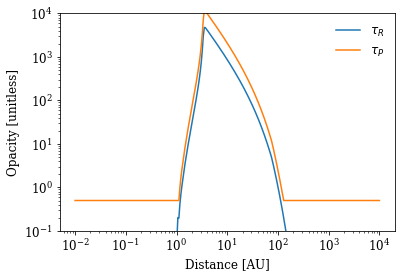

In [ ]:
plt.loglog(r, tau_R(T[-1], Σ_initial(r_au)), label = '$τ_R$')
plt.loglog(r, tau_P(tau_R(T[-1], Σ_initial(r_au))), label = '$τ_P$')
plt.ylim(0.1, 1e4)
plt.legend(frameon = False)
plt.ylabel('Opacity [unitless]' )
plt.xlabel('Distance [AU]')